<a href="https://colab.research.google.com/github/AnnaBobasheva/KG-R/blob/main/KG_and_Classification_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Applying statistical classification methods to meteorological data knowledge graph WeKG-MF
**beta version**
#### maintained by the [WIMMICS team](https://team.inria.fr/wimmics/)
This notebook demonstrates how to access and query WeKG-MF RDF dataset and apply classification methods to the query results. In this notebook, we are going to explore how to use meteorological data and statistical models to classify wine growing regions and grape varieties.

The WeKG-MF dataset offers access to a large set of meteorological variables described through spatial and temporal dimensions.

The full description of the dataset can be found here: https://github.com/Wimmics/weather-kg/tree/main/meteo.

SPARQL query endpoint: http://weakg.i3s.unice.fr/sparql.

NOTE: Although this notebook closely resembles the notebook in R it does not produce exactly the same results. This is due to the data updates and the difference in the default parameters of the models used by R and Python packages.

**REFERENCES:**

Nadia Yacoubi Ayadi, Catherine Faron, Franck Michel, Fabien Gandon, Olivier Corby. WeKG-MF: a Knowledge Graph of Observational Weather Data. ESWC 2022 - 19th Extended Semantic Web Conference, May 2022, Hersonissos, Greece. https://hal.inria.fr/hal-03657694/file/WeKG-MF-Poster-ESWC-2022.pdf

Winkler, Albert Julius. General viticulture. Univ of California Press, 1974. Book.

Jones, Gregory V., Andrew A. Duff, Andrew Hall, and Joseph W. Myers. "Spatial analysis of climate in winegrape growing regions in the western United States." American Journal of Enology and Viticulture 61, no. 3 (2010): 313-326. https://researchoutput.csu.edu.au/ws/portalfiles/portal/8768033/postpubPID19814.pdf

Van Leeuwen, CornelIs, C. Garnier, C. Agut, Bernard Baculat, Gerard Barbeau, E. Besnard, B. Bois et al. "Heat requirements for grapevine varieties is essential information to adapt plant material in a changing climate." In 7. Congrès International des Terroirs Viticoles. 2008. https://hal.inrae.fr/hal-02758537/file/28929_20110210031815860_1.pdf

## Setup

In [1]:
import sys
print(sys.version_info)

colab = 'google.colab' in sys.modules
if colab:
  import google.colab
  print(f"Google Colab Version: {google.colab.__version__}")

import os
conda = os.environ.get('CONDA_DEFAULT_ENV')

if conda:
  print(f'The runtime {conda} environment is a Conda distribution')

sys.version_info(major=3, minor=10, micro=12, releaselevel='final', serial=0)
Google Colab Version: 0.0.1a2


### Enabling querying of the Knowledge Graph  

In this notebook we demonstrate use of [Corese-library with Python](https://github.com/Wimmics/corese/blob/master/docs/corese-python/Corese-library%20with%20Python.md) which is a Python wrapper of CORESE Java library.

**CORESE (COnceptual REsource Search Engine)** is a software platform implementing and extending the standards of the Semantic Web. It allows to create, manipulate, parse, serialize, query, reason and validate RDF data. Detailed description of the CORESE software can be found [here](https://github.com/Wimmics/corese).

To enable the use of CORESE library the VM that runs this notebook has to have Java installed and the library has to be downloaded to a locaton accessible by this notebook.

In [2]:
!java --version

openjdk 11.0.21 2023-10-17
OpenJDK Runtime Environment (build 11.0.21+9-post-Ubuntu-0ubuntu122.04)
OpenJDK 64-Bit Server VM (build 11.0.21+9-post-Ubuntu-0ubuntu122.04, mixed mode, sharing)


In [ ]:
if conda:
    !conda install conda-forge::py4j
else:
    !pip install py4j

#### Download CORESE library

The CORESE library is in development and maybe updated often. Refer to the [documetation](https://github.com/Wimmics/corese/blob/master/docs/corese-python/Corese-library%20with%20Python.md) for the latest version and isntructions.

In [4]:
import os

corese_latest = 'corese-library-python-4.5.0.jar'

if not os.path.exists(corese_latest):
  #!wget "http://files.inria.fr/corese/distrib/corese-library-python-4.4.1.jar" -P "/content/drive/My Drive/KG+Python"
  !curl "http://files.inria.fr/corese/distrib/{corese_latest}" -o "{corese_latest}"
else:
  print("CORESE is already downloaded")

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 27.0M  100 27.0M    0     0  81.8M      0 --:--:-- --:--:-- --:--:-- 81.8M


#### Launch CORESE engine



In [5]:
import atexit
import subprocess
from time import sleep
from io import StringIO

from py4j.java_gateway import JavaGateway

# Start java gateway

java_process = subprocess.Popen(
      ['java', '-jar', '-Dfile.encoding=UTF-8', corese_latest])

sleep(1)

gateway = JavaGateway()

sleep(3)

# Stop java gateway at the enf od script
def exit_handler():
    gateway.shutdown()
    print('\n' * 2)
    print('Gateway Server Stop!')

atexit.register(exit_handler)


<function __main__.exit_handler()>

#### Define dataset endpoint for the SPARQL data access

In [6]:
endpoint = 'http://weakg.i3s.unice.fr/sparql'

#### Define prefixes to abbreviate namespaces

NOTE: for the namespaces to render correctly in HTML (think Github) we add extra spaces around angle brackets. These spaces are immediately removed for the query to work.

In [7]:
sparql_prefix = '''
PREFIX xsd: < http://www.w3.org/2001/XMLSchema# >
PREFIX dct: < http://purl.org/dc/terms/ >
PREFIX rdfs: < http://www.w3.org/2000/01/rdf-schema# >

PREFIX qudt: < http://qudt.org/schema/qudt/ >
PREFIX wdt: < http://www.wikidata.org/prop/direct/ >
PREFIX geosparql:  < http://www.opengis.net/ont/geosparql# >
PREFIX qb: < http://purl.org/linked-data/cube# >
PREFIX sosa: < http://www.w3.org/ns/sosa/ >

PREFIX weo: < http://ns.inria.fr/meteo/ontology/ >
PREFIX wep: < http://ns.inria.fr/meteo/ontology/property/ >
PREFIX wevp: < http://ns.inria.fr/meteo/vocab/weatherproperty/ >
PREFIX wes-dimension: < http://ns.inria.fr/meteo/observationslice/dimension# >
PREFIX wes-measure: < http://ns.inria.fr/meteo/observationslice/measure# >
PREFIX wes-attribute: < http://ns.inria.fr/meteo/observationslice/attribute# >
PREFIX wevp-agro: < http://ns.inria.fr/meteo/vocab/agroclimatic/growingDegreeDay >

PREFIX geo: < http://www.w3.org/2003/01/geo/wgs84_pos# >

# returned data prefixes
PREFIX qudtu: < http://qudt.org/vocab/unit/ >
PREFIX wd:    < http://www.wikidata.org/entity/ >
PREFIX wdt:   < http://www.wikidata.org/prop/direct/ >
PREFIX wes:   < http://ns.inria.fr/meteo/weatherstation/ >

'''
sparql_prefix = sparql_prefix.replace('< ', '<')
sparql_prefix = sparql_prefix.replace(" >", ">")

#### Define helper functions

In [8]:
import pandas as pd
# Import classes
Graph = gateway.jvm.fr.inria.corese.core.Graph
Load = gateway.jvm.fr.inria.corese.core.load.Load
Transformer = gateway.jvm.fr.inria.corese.core.transform.Transformer
QueryProcess = gateway.jvm.fr.inria.corese.core.query.QueryProcess
RDF = gateway.jvm.fr.inria.corese.core.logic.RDF
RDFS = gateway.jvm.fr.inria.corese.core.logic.RDFS
ResultFormat = gateway.jvm.fr.inria.corese.core.print.ResultFormat
Transformer = gateway.jvm.fr.inria.corese.core.transform.Transformer

# Run query and convert the output to a DataFrame

def sparqlQuery(graph, prefixes, query, dtypes=None):
    exec = QueryProcess.create(graph)
    map = exec.query('\n'.join([prefixes, query]) )

    resultFormat = ResultFormat.create(map, ResultFormat.SPARQL_RESULTS_CSV)
    df = pd.read_csv(StringIO(resultFormat.toString()),
                     skipinitialspace=True,
                     dtype=dtypes)

    # Assign n/a to empty strings
    string_dtypes = df.convert_dtypes().select_dtypes("string")
    df[string_dtypes.columns] = string_dtypes.replace(r'^\s*$', None, regex=True)

    return map, df
#TODO remove maps
def sparqlConstruct(graph, prefixes, query, dtype=None):

    exec = QueryProcess.create(graph)
    map = exec.query('\n'.join([prefixes, query]) )

    graph.merge(map.getGraph())
    return map, graph

def toTurtle(graph):
  return Transformer.create(graph, Transformer.TURTLE).toString()

def printSize(graph):
  return graph.getDatatypeLabel()

def exportGraph(graph, path, format=Transformer.TURTLE):
    transformer = Transformer.create(graph, format)
    transformer.write(path)

def loadGraph(path):
    graph = Graph()

    ld = Load.create(graph)
    ld.parse(path)

    return graph

In [9]:
Shacl = gateway.jvm.fr.inria.corese.core.shacl.Shacl

prefix_shacl = '''
@prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .
@prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .
@prefix sh: <http://www.w3.org/ns/shacl#> .
'''

def shaclValidate(graph, shacl_shape_ttl):

  #TODO: try to not save the file
  shape_file = 'shape.ttl'
  with open(shape_file, 'w') as file:
      file.write(prefix_shacl)
      file.write(shacl_shape_ttl)

  # Load shape graph
  shapeGraph = Graph()
  ld = Load.create(shapeGraph)
  ld.parse(shape_file)

  # Evaluation
  shacl = Shacl(graph, shapeGraph)
  result = shacl.eval()

  return result

# Parse validation results
def shaclValidationReport(validation_report_graph):
  prefix = 'PREFIX sh: <http://www.w3.org/ns/shacl#>'
  query='''SELECT ?o ?p ?s
            WHERE { ?o a sh:ValidationResult.
                  ?o  ?p ?s.
            }'''
  _, report = sparqlQuery(validation_report_graph, prefix, query)

  report = report.pivot(index='o', columns='p', values='s')
  report.columns = [uri.split('#')[-1] for uri in report.columns]

  return report


### Enabling visualization tools

For charting the data we will be using packages:
- `matplotlib` - generates plots, histograms, bar charts, errorcharts, scatterplots, etc., with just a few lines of code
- `seaborn` - data visualization library based on matplotlib thatbprovides a high-level interface for drawing attractive and informative statistical graphics
- `matplotlib_venn` - routines for plotting area-weighted two- and three-circle venn diagrams.
- `dtreeviz` - elaborate decision tree visualization

NOTE: `matplotlib` and `seaborn` usually come with Python distribution (at least it's true for Google Colab runtimes). If this is not the case install the me using either by runnng  `pip install matplotlib seaborn` or `conda install matplotlib seaborn`.

In [10]:
import matplotlib.pyplot as plt
import matplotlib.patches
import seaborn as sns

In [11]:
from matplotlib_venn import venn2

In [ ]:
if conda:
  !conda install conda-forge::dtreeviz
else:
  !pip install dtreeviz

import dtreeviz

### Enabling data manipulation tools

For easy manipulations of data we use packages:
- `pandas` - most commonly used package for data wrangling and data manipulation
- `numpy` - support for multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays
- `skrub` - we'll try to use this new package that facilitates preparing tables for machine learning

NOTE: `pandas` and `numpy` are usually preinstalled.

In [13]:
import pandas as pd
import numpy as np

In [14]:
if conda:
  !conda install conda-forge::skrub
else:
  !pip install skrub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.6/141.6 kB 3.6 MB/s eta 0:00:00


In [15]:
# Define a helper function that adds missing data counts and datatypes to the
# pandas DataFrame description
def describe_dataframe(df):
  return pd.concat( [df.describe(include = 'all'),
                     df.isna().sum(axis=0).to_frame().transpose().set_index( pd.Index(['NaNs'] )),
                     df.dtypes.to_frame().transpose().set_index( pd.Index(['Dtypes'] ))])\
           .transpose()

## Preparing the dataset

In this notebook we demonstarte how to load the data from multiple sources or queries to the local triple store (CORESE) and work with the localally stored graph. The benefit of this approach is in "owing your graph" that allows:

- combine graphs from heterogeneus resources such as endpoint and RDF files
- shaping the structure of the graph to suit better to the consequent analysis
- saving and loading the results for reproducibility

#### Construct new graph of weather staions from WeKG

Query the data from the WeKG into CORESE to build a "local" graph with the data subset that we need. For simplicity reasons we only consider the weather stations from the northern hemisphere.

In [16]:
construct_query_stations = f'''
CONSTRUCT
{{
  ?station a <http://ns.inria.fr/meteo/ontology/WeatherStation>;
  rdfs:label ?stationName;
                    geo:lat ?lat;
                    geo:long ?long;
                    geo:altitude ?alt;
                    dct:Location ?regionLabel.
}}
WHERE {{
  SERVICE <{endpoint}>
  {{
      ?station rdfs:label ?stationName;
                  geo:lat ?lat;
                  geo:long ?long;
                  geo:altitude ?alt.

        OPTIONAL {{ ?station dct:spatial/wdt:P131 ?region.
                    ?region rdfs:label ?regionLabel;
                            wdt:P2585 ?regionCode.}}
        FILTER (?lat > 0) # only northern hemisphere
  }}

}}

'''

graph = Graph()
_, graph = sparqlConstruct(graph, sparql_prefix, construct_query_stations)

#print(graph)
print(printSize(graph))

[Graph: size=310]


### Fill missing regions in the graph

We can identify the missing values in the graph by using [Shapes Constraint Language (SHACL)](https://www.w3.org/TR/shacl/)

In [17]:
missing_region_shacl = '''
@prefix sh: <http://www.w3.org/ns/shacl#> .
@prefix dct: <http://purl.org/dc/terms/> .
@prefix weo: <http://ns.inria.fr/meteo/ontology/>

# Define a SHACL shape for resources with missing labels
ex:MissingLabelShape
    a sh:NodeShape ;
    sh:targetClass weo:WeatherStation ;
    sh:property [
        sh:path dct:Location ;  # Check for the location property
        sh:minCount 1 ;         # Ensure at least one label exists
        sh:message "Station is missing a region" ;  # Custom error message
    ] .
'''

result = shaclValidate(graph, missing_region_shacl)

missing_regions = shaclValidationReport(result)

missing_regions

,type,focusNode,resultMessage,resultPath,resultSeverity,sourceConstraintComponent,sourceShape,value
o,,,,,,,,
urn:uuid:4cfd6b54-d9c2-44a7-9834-1ab826ef8c81,http://www.w3.org/ns/shacl#ValidationResult,http://ns.inria.fr/meteo/weatherstation/71805,Station is missing a region,http://purl.org/dc/terms/Location,http://www.w3.org/ns/shacl#Violation,http://www.w3.org/ns/shacl#MinCountConstraintC...,_:b0,0
urn:uuid:d23aabb1-beb7-4f79-a81c-f653a09a298c,http://www.w3.org/ns/shacl#ValidationResult,http://ns.inria.fr/meteo/weatherstation/78894,Station is missing a region,http://purl.org/dc/terms/Location,http://www.w3.org/ns/shacl#Violation,http://www.w3.org/ns/shacl#MinCountConstraintC...,_:b0,0


In [18]:
# Assign the station rdfs:label as a region label in a triple
# station_IRI dc:Location stationNameLabel

for _, row in missing_regions.iterrows():
  print('Adding region to the station:')
  station_IRI = graph.getResource(row.focusNode)
  print(station_IRI)

  missing_predicate = graph.getResource(row.resultPath)

  # Get station name from the main graph
  # it is a bit cumbersome with the Java calls and p4j
  label_node = graph.getResource(RDFS.LABEL)
  #TODO: extract method
  station_name = graph.getEdgesRDF4J(station_IRI, label_node, None, None)

  java_iterator = station_name.iterator()
  if station_name.iterator().hasNext():
    missing_region_label = java_iterator.next().getObjectNode()
    print(missing_region_label.getLabel())

  graph.addEdge(station_IRI, missing_predicate, missing_region_label)

# Evaluate again
result = shaclValidate(graph, missing_region_shacl)
print(toTurtle(result))

print(printSize(graph))

Adding region to the station:
<http://ns.inria.fr/meteo/weatherstation/71805>
ST-PIERRE
Adding region to the station:
<http://ns.inria.fr/meteo/weatherstation/78894>
ST-BARTHELEMY METEO
@prefix xsh: <http://www.w3.org/ns/shacl#> .
@prefix sh: <http://www.w3.org/ns/shacl#> .

[a sh:ValidationReport ;
  sh:conforms true] .


[Graph: size=312]


### Add agroclimatic data from WeKG


**GDD** - Growing Degree Days, is a measure of heat accumulation used by viticulturists (cultivators of grapevine) to assess the growth and development of grapevines. It is calculated by taking the average daily temperature, subtracting a base temperature (usually 10°C), and then summing the resulting values over the course of the season (April to September in the northern hemisphere).

**GST** - Growing Season Temperature, can provide another bioclimatic index for identifying regions of cool and very cool climates. GST is calculated by averaging the average daily temperature over the course of the growing season.

**Rainfall** is the amount of liquid precipitation (rain, sleet, snow, etc.) that falls from the sky over a given time period. Viticulturists use rainfall data to assess the moisture levels in the soil and to determine if irrigation is necessary. The cumulative rainfall is calculated from January to October in the northern hemisphere.

We can calculate GDD, GST, and rainfall in a query itself.

In [19]:
construct_query_temperatures = f'''
CONSTRUCT
{{
  ?station sosa:hasFeatureOfInterest [ wes-dimension:year ?year  ;
                                       wevp-agro:growingDegreeDay ?GDD;
                                       wevp-agro:growingSeasonAvgTemperature ?GST
                                     ] .
}}
WHERE {{
  SERVICE <{endpoint}>
  {{
    SELECT ?station ?year
           (SUM(?gdd) as ?GDD)
           (AVG(?temp_avg) as ?GST)
    WHERE {{
          ?s a qb:Slice ;
           wes-dimension:station ?station ;
           qb:observation [ a qb:Observation ;
                            wes-attribute:observationDate ?date ;
                            wes-measure:avgDailyTemperature ?temp_avg]

           BIND( IF( ?temp_avg > 10 , ?temp_avg - 10, 0)  as ?gdd)
           FILTER  ( MONTH(?date) > 3 && MONTH(?date) < 11)
           BIND ( YEAR(?date) AS  ?year )
           }}
           GROUP BY ?station ?year
  }}

}}
'''

_, graph = sparqlConstruct(graph, sparql_prefix, construct_query_temperatures)
#print(graph)
print(printSize(graph))

[Graph: size=2924]


In [20]:
construct_query_rainfall = f'''
CONSTRUCT
{{
  ?station sosa:hasFeatureOfInterest [ wes-dimension:year ?year  ;
                                       wevp-agro:yearlyRainfall ?rainfall]
}}
WHERE {{
  SERVICE <{endpoint}>
  {{
    SELECT ?station ?year
          (SUM(?precipitation_cum) as ?rainfall)

    WHERE {{
          ?s a qb:Slice ;
           wes-dimension:station ?station ;
           qb:observation [ a qb:Observation ;
                           wes-attribute:observationDate ?date ;
                           wes-measure:rainfall24h ?precipitation_cum]

           FILTER  ( MONTH(?date) < 11)

           BIND (YEAR(?date) AS ?year)

           }}
           GROUP BY ?station ?year
  }}
}}
'''

map, graph = sparqlConstruct(graph, sparql_prefix, construct_query_rainfall)

#print(graph)
print(printSize(graph))

[Graph: size=4784]


### Load the grapevine graph

We did some cursory research on [viticulture](https://en.wikipedia.org/wiki/Viticulture) in the areas surrounding the weather stations. We created a small Knowlege Graph of [grapevines](https://github.com/Wimmics/kgstat/blob/main/data/grapevines.ttl) in Terse RDF Triple Language ([Turtle](https://www.w3.org/TR/turtle/)) modeled with well-known [Wine Ontology](http://oaei.ontologymatching.org/2007/benchmarks/102/onto.html).

We will use the viticulture graph for supervised classification.

In [21]:
ld = Load.create(graph)
ld.parse('https://raw.githubusercontent.com/Wimmics/kgstat/main/data/grapevines.ttl')

print(printSize(graph))

[Graph: size=4865]


### Query the local graph

In [22]:
query_station_geo_agro = '''
SELECT ?region
       ?station
       ?stationName
       ?lat ?long ?alt
       ?year
       ?GDD ?GST ?rainfall

WHERE {

   ?station rdfs:label ?stationName;
            geo:lat ?lat;
            geo:long ?long;
            geo:altitude ?alt.

   OPTIONAL{ ?station dct:Location ?region }

   OPTIONAL {
   ?station sosa:hasFeatureOfInterest [ wes-dimension:year ?year  ;
                                        wevp-agro:growingDegreeDay ?GDD;
                                        wevp-agro:growingSeasonAvgTemperature ?GST
                                     ] .
    }
   OPTIONAL {
    ?station sosa:hasFeatureOfInterest [ wes-dimension:year ?year  ;
                                         wevp-agro:yearlyRainfall ?rainfall
                                     ] .
   }
}
#GROUP BY ?stationName ?year
ORDER BY ?stationName ?year

'''

_ , station_geo_agro_df = sparqlQuery(graph, sparql_prefix,
                                      query_station_geo_agro,
                                      dtypes= { 'alt': 'float'})

station_geo_agro_df.shape


(559, 10)

In [23]:
describe_dataframe(station_geo_agro_df).transpose().drop(index='top')

,region,station,stationName,lat,long,alt,year,GDD,GST,rainfall
count,559,559,559,559.0,559.0,559.0,559.0,559.0,559.0,549.0
unique,18,52,52,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,77,11,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,40.531718,-8.250078,147.926655,2017.010733,1826.207961,18.646075,719.2051
std,NaN,NaN,NaN,13.604213,23.101885,198.88137,3.142932,849.571793,4.415415,582.515266
min,NaN,NaN,NaN,3.640167,-62.852167,2.0,2012.0,376.6,9.885047,92.2
25%,NaN,NaN,NaN,43.079333,-1.939833,21.0,2014.0,1275.075,15.781075,464.3
50%,NaN,NaN,NaN,45.7265,1.181667,73.0,2017.0,1533.0,17.083411,566.4
75%,NaN,NaN,NaN,48.324667,4.087666,161.0,2020.0,2160.65,20.30691,719.5
max,NaN,NaN,NaN,50.57,9.485167,871.0,2022.0,4078.55,29.058645,4738.2


In [24]:
# Fill N/A in regions (it was taking care in Fill missing region section)
# but I left the code to compare the amount of code needed
station_geo_agro_df.region.fillna(station_geo_agro_df.stationName.str.capitalize(), inplace=True)

station_geo_agro_df.rainfall.fillna( station_geo_agro_df.groupby('stationName').rainfall.transform('mean'), inplace=True)
station_geo_agro_df.GDD.fillna( station_geo_agro_df.groupby('stationName').GDD.transform('mean'), inplace=True)

# Do not consider rows with other blanks
station_geo_agro_df.dropna(axis=0, inplace=True)

### Label the weather stations with Winkler Index

The Winkler Index is a technique for classifying the climate of wine growing regions based on heat summation or GDD. In the system, geographical areas are divided into five climate regions based on temperature converted to growing degree-days, and are commonly known as Regions I–V.

We can use the calculated GDD value to classify the geographical locations into different wine growing regions. For example, you might use the following GDD ranges to classify French wines:

>| GDD (°C) | Region | Characteristics |
>| :----:   | :----  |:--------------- |
>|       less than 850     | Too cool          |
>|       850 to 1389       | Region I          | Wines are made from cool-climate grape varieties, such as Chardonnay, Sauvignon Blanc, Pinot Noir, <br> and Riesling. These wines tend to be light-bodied and crisp, with fresh acidity and delicate flavors.<br> Typical French regions: Champagne, Alsace, Burgundy, Loire Valley, Savoie. |
>|       1389 to 1667      | Region II         | Wines made from grape varieties that thrive in moderate climates, such as Syrah, Merlot, and <br> Cabernet Sauvignon. These wines tend to have medium-bodied, fruity flavors and medium <br> to high tannins. Typical French regions: Bordeaux. |
>|       1667 to 1944      | Region III        | Wines made from warm-climate grape varieties, such as Grenache, Carignan, and Mourvèdre.<br> These wines tend to be full-bodied, with ripe, bold flavors and high alcohol levels.<br> Typical French regions: Nothern Rhône. |
>|       1944 to 2222      | Region IV         | Wines are favorable for high production, but acceptable table wine quality at best.<br> Typical French regions: Languedoc, Roussillon, Southern Rhône, and Corsica.|
>|       2222 to 2700      | Region V          | Typically only suitable for extremely high production, fair quality table wine or table grape varieties<br> destined for early season consumption are grown. May not be applicable to France.|
>|     greater than 2700 | Too hot          ||

NOTE that this is just one possible way to classify region based on GDD and is used here just for the demonstration.
http://passion.vignobles.free.fr/section_vignes/Les%20besoins%20agro-climatiques.php

In [25]:
from sklearn.preprocessing import FunctionTransformer

winkler_labels=["Too cool", "Region I", "Region II",
                "Region III", "Region IV", "Region V", "Too hot" ]
winkler_bins = [0, 850, 1389, 1667, 1944, 2222, 2700, 10000]

winkler_discretizer = FunctionTransformer(pd.cut,
                                          kw_args={'bins': winkler_bins,
                                                   'labels': winkler_labels,
                                                   'right': True})

station_geo_agro_df['winkler_index'] = winkler_discretizer.fit_transform(station_geo_agro_df.GDD)

In [26]:
#TODO add the Winkler Index to the graph??

### Average values per weather station over the years

In [27]:
station_geo_agro_df_avg = station_geo_agro_df.groupby('stationName')\
                               .agg('mean', numeric_only=True)
# Reassign region
station_geo_agro_df_avg['region'] = station_geo_agro_df.groupby('stationName').region.first()

# Recalculate Winkler index base on avearage GDD
station_geo_agro_df_avg['winkler_index']  = winkler_discretizer.fit_transform(station_geo_agro_df_avg.GDD)

station_geo_agro_df_avg['winkler_index'].value_counts(sort=False)

Too cool       1
Region I      16
Region II     14
Region III     3
Region IV      5
Region V       5
Too hot        8
Name: winkler_index, dtype: int64

## Unsupervised classification (clustering)

We'd like to see if there is a way to group the weather stations based on their bioclimatic variables GDD and rainfall.

As the number of clusters we select the same number as Winckler classes (7). If we are lucky they may align.

For visualization reasons, we minimize the number of data points by averaging the bioclimatic values over the years for each weather station.

### K-means cluster analysis

Clustering allows us to identify which observations are alike, and potentially categorize them. K-means clustering is the simplest and the most commonly used clustering method for splitting a dataset into a set of k groups.

In [28]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer
from skrub import SelectCols

GDD_rainfall_km = station_geo_agro_df_avg.loc[:, ['GDD', 'rainfall']]

scaler = MinMaxScaler(copy=False).set_output(transform='pandas')
GDD_rainfall_km = scaler.fit_transform(GDD_rainfall_km)

#TODO: add hyperparameter search?
k = 5
km = KMeans(k, random_state=42, n_init=10, algorithm='lloyd' )
km.fit(GDD_rainfall_km)

GDD_rainfall_km['cluster'] = km.labels_

# Basic plot - delete
#GDD_rainfall_km.plot.scatter('GDD', 'rainfall', c=km.labels_, colormap='viridis')

<ipython-input-29-4837693ed1b1>:51: RuntimeWarning: invalid value encountered in sqrt


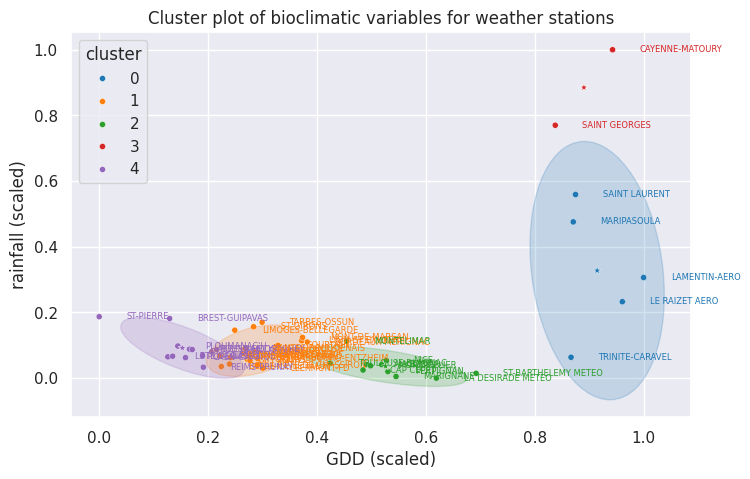

In [29]:
#TODO: add regions to labels
plt.figure(figsize=(8, 5))
sns.set_theme()

# define color palete, it should be qualitative
# https://seaborn.pydata.org/tutorial/color_palettes.html
# other palettes options 'muted', 'bright'
colors= sns.color_palette('tab10', k)

scatter = sns.scatterplot(x=GDD_rainfall_km.GDD,
                          y=GDD_rainfall_km.rainfall,
                          hue=GDD_rainfall_km.cluster,
                          palette=colors, s=20) #viridis , alpha=0.8

# Plot cluster centers
sns.scatterplot(x=km.cluster_centers_[:, 0],
                y=km.cluster_centers_[:, 1],
                color=colors,
                marker='*',
                s=40)


# Plot point labels
for i, label in enumerate(GDD_rainfall_km.index):
    scatter.text(GDD_rainfall_km.GDD[i] + 0.05,
                 GDD_rainfall_km.rainfall[i],
                 label,
                 fontsize=6,
                 color=colors [GDD_rainfall_km.cluster[i] ],
                 ha='left', va='center')

# Plot cluster ellipses
#TODO extract method
for i in range(k):
    # Get the points belonging to cluster i
    cluster_i = GDD_rainfall_km.loc[GDD_rainfall_km.cluster == i, ['GDD', 'rainfall']]

    if cluster_i.shape[0] > 1:

      # Compute the covariance matrix of cluster i
      cov_i = np.cov(cluster_i.T)

      # Compute the eigenvalues and eigenvectors of the covariance matrix
      eigvals_i, eigvecs_i = np.linalg.eig(cov_i)

      # Compute the angle of rotation of the ellipse
      theta_i = np.degrees(np.arctan2(*eigvecs_i[:, 0][::-1]))

      # Compute the width and height of the ellipse

      width_i, height_i = 4 * np.sqrt(eigvals_i)

    else:
      width_i, height_i, theta_i =  (0.0, 0.0, 0.0)

    #print(width_i, height_i)

    # Plot the ellipse
    ellipse_i = matplotlib.patches.Ellipse(xy=km.cluster_centers_[i],
                                           width=width_i,
                                           height=height_i,
                                           angle=theta_i,
                                           alpha=0.2,
                                           color=colors[i])
    plt.gca().add_patch(ellipse_i)

plt.title('Cluster plot of bioclimatic variables for weather stations')
plt.legend(title='cluster', loc='upper left')
plt.ylabel('rainfall (scaled)')
plt.xlabel('GDD (scaled)')
plt.show()

### Compare clustering and Winkler index classes
Let's see if the Winkler regions and clusters are aligned by plotting a bar plot where the bars correspond to each cluster, the height of the bar represents the number of stations in the cluster, and the color represents the Winkler index of counted stations.

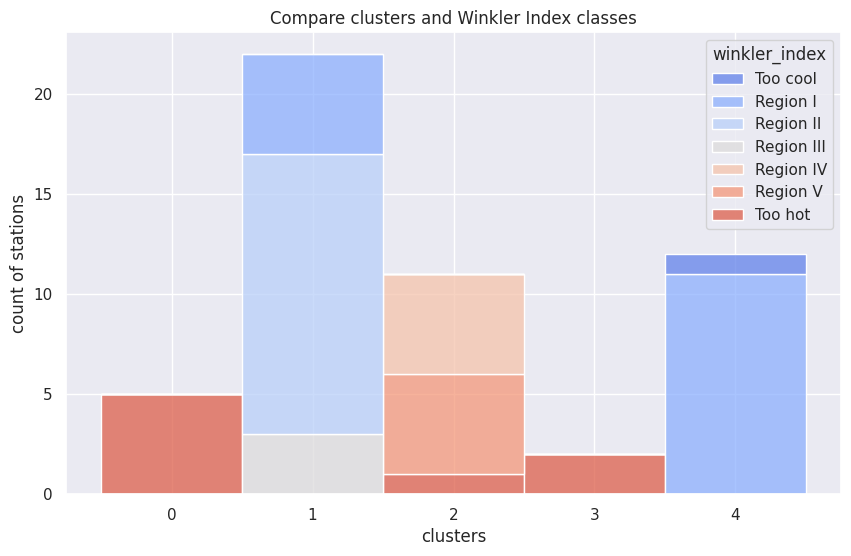

In [30]:
plt.figure(figsize=(10, 6))
sns.set_theme()

#station_geo_agro_df_avg['cluster'] =  km.labels_

#TODO: custom palette
sns.histplot(#data=station_geo_agro_df_avg,
            x=  km.labels_,#'cluster',
            hue=station_geo_agro_df_avg.winkler_index,#'winkler_index',
            stat='count',
            discrete=True,
            palette='coolwarm',
            multiple='stack')

plt.title('Compare clusters and Winkler Index classes')
#plt.legend(labels=list(reversed(winkler_labels)), reverse=True,  title='Winkler Index' )
plt.xlabel('clusters')
plt.ylabel('count of stations')
print()

OBSERVATIONS AND CONCLUSIONS

---

Although there is no exact match between K-mean clusters and Winkler Index we still can see that the "too cold" and "too hot" regions are separated from the rest in the clusters 0, 3, and 4.


### Visualize regions sets based on clusters
Let's put the regions of the stations from the cluster "wine producing areas" in one set and the regions of other stations in another. We can plot the sets on Venn diagram and see how they intersect.

In [31]:
interesting_clusters = [1,2]

wine_regions  = set(station_geo_agro_df_avg.loc[GDD_rainfall_km.cluster.isin(interesting_clusters) , 'region'])
cider_regions = set(station_geo_agro_df_avg.loc[GDD_rainfall_km.cluster.isin(interesting_clusters) == False, 'region'])

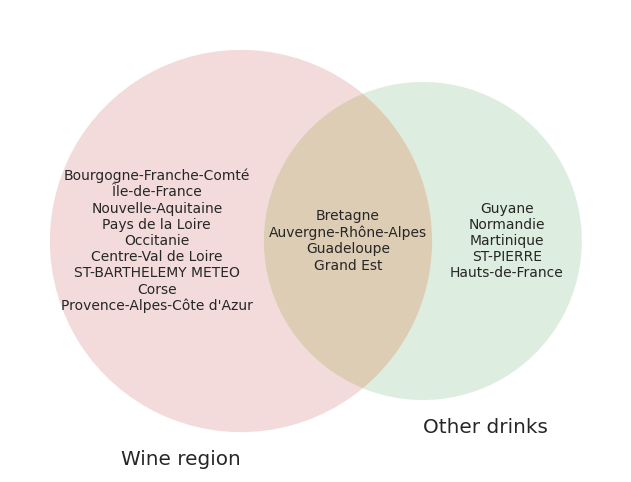

In [32]:
plt.figure(figsize=(10, 6))
sns.set_theme()

# Create a Venn diagram with custom labels
venn_diagram  = venn2( [wine_regions , cider_regions],
                        set_labels = ('Wine region', 'Other drinks'))

only_wine = '\n'.join(wine_regions.difference(cider_regions))
venn_diagram.get_label_by_id('10').set_text( only_wine )
venn_diagram.get_label_by_id('10').set_fontsize(10)

venn_diagram.get_patch_by_id('10').set_alpha(0.2)

only_cider = '\n'.join(cider_regions.difference(wine_regions))
venn_diagram.get_label_by_id('01').set_text( only_cider )
venn_diagram.get_label_by_id('01').set_fontsize(10)

venn_diagram.get_patch_by_id('01').set_alpha(0.2)

wine_and_cider = '\n'.join(cider_regions.intersection(wine_regions))
venn_diagram.get_label_by_id('11').set_text( wine_and_cider )
venn_diagram.get_label_by_id('11').set_fontsize(10)

venn_diagram.get_patch_by_id('11').set_alpha(0.6)
# Display the plot
plt.show()

OBSERVATONS AND CONCLUSIONS:


---



- the separation of the regions is very close to real life
- regions, where wine grapevines grow everywhere are identified e.g. Burgundy or Loire Valley
- regions with too hot and too cold weather e.g Martinique or Normandie
- and all the others are in between
- one real mistake is St.Barthelemy as it does not produce wine

### Principal Component Analysis
Principal Component Analysis (PCA) is a useful technique for exploratory data analysis, allowing you to better visualize the variation present in a dataset with many variables.

The first principal component (PC1) explains the most variance in the data, the second principal component (PC2) explains the second most variance, and so on. The loading of the eigenvector represents how important each original variable is to the component.

We can combine agroclimatic and geospatial variables of wine growing regions and analyze if there is any correlation between them.

In [33]:
from sklearn.decomposition import PCA

GDD_rainfall_pca = station_geo_agro_df.select_dtypes(include={'float64'})

scaler = StandardScaler(copy=False).set_output(transform='pandas')
scaler.fit_transform(GDD_rainfall_pca)

pca = PCA()
_ = pca.fit_transform(GDD_rainfall_pca)

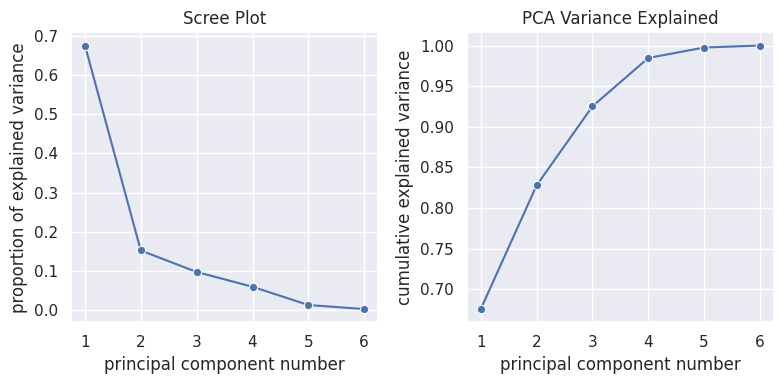

In [34]:
# Scree plot
plt.figure(figsize=(8, 4))
sns.set_theme()
#sns.set_theme(context='notebook', style='darkgrid', palette='deep',
#              font='sans-serif', font_scale=1, color_codes=True, rc=None)

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

plt.subplot(1, 2, 1)
sns.lineplot(x=range(1, len(explained_variance_ratio) + 1),
             y=explained_variance_ratio,
             marker='o')

plt.title('Scree Plot')
plt.xlabel('principal component number')
plt.ylabel('proportion of explained variance')

plt.subplot(1, 2, 2)
sns.lineplot(x=range(1, len(explained_variance_ratio) + 1),
             y=cumulative_variance,
             marker='o')

plt.title('PCA Variance Explained')
plt.xlabel('principal component number')
plt.ylabel('cumulative explained variance')


plt.tight_layout()
plt.show()


OBSERVATIONS:


---

- from the plots above we can see that using 2 PCA components explains over 80% of data variance. So instead of using 3 geo loaction variables and 3 agroclimatic variables in classification we can just use 2 PCA components.


With only 2 components we can visualize the data on a 2D plot to observe the possible clustering tendencies of multiple predictors.


In [35]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(GDD_rainfall_pca)

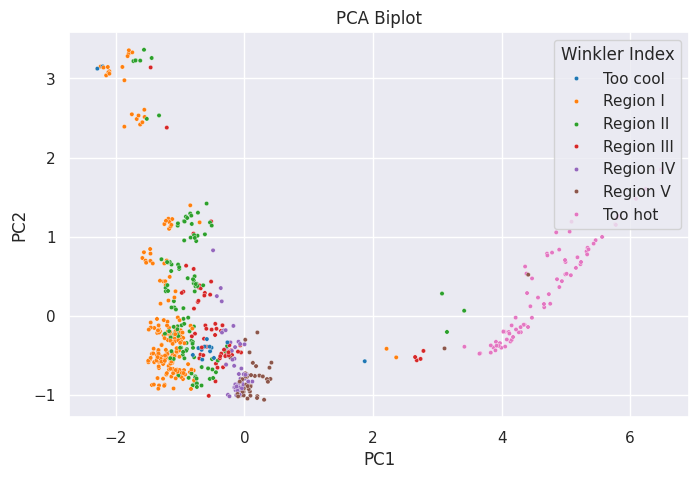

In [36]:
plt.figure(figsize=(8, 5))

sns.scatterplot(x=pca_result[:, 0],
                y=pca_result[:, 1],
                hue= station_geo_agro_df.winkler_index, #'winkler_index',
                palette='tab10',
                s=10)

# Set labels and title
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA Biplot')
plt.legend(title='Winkler Index', loc='upper right')


plt.show()

OBSERVATIONS:


---

- on this plot it looks like the PCA components are clustered in resemblance of the Winkler Index categories  



## Supervised classification

For the classification we will label the weather stations with:

- binary "yes" and "no"
- prevalent white wine grape varieties (fr: cepage)
- prevalent red wine grape varieties

In [37]:
#TODO: query the graph for all of the values instead of merging
query_station_geo_agro_cepage = '''
PREFIX vin: <http://www.w3.org/TR/2003/PR-owl-guide-20031209/wine#>

SELECT ?region
       ?station
       ?stationName
       ?lat ?long ?alt
       ?year
       ?GDD ?GST ?rainfall

WHERE {

   ?station rdfs:label ?stationName;
            geo:lat ?lat;
            geo:long ?long;
            geo:altitude ?alt.

   OPTIONAL{ ?station dct:Location ?region }

   OPTIONAL {
   ?station sosa:hasFeatureOfInterest [ wes-dimension:year ?year  ;
                                        wevp-agro:growingDegreeDay ?GDD;
                                        wevp-agro:growingSeasonAvgTemperature ?GST
                                     ] .
    }
   OPTIONAL {
    ?station sosa:hasFeatureOfInterest [ wes-dimension:year ?year  ;
                                         wevp-agro:yearlyRainfall ?rainfall
                                     ] .
   }

   OPTIONAL {
    ?cepage vin:locatedIn ?station;
                vin:madeIntoWine ?type.
   }
}
#GROUP BY ?stationName ?year
ORDER BY ?stationName ?year

'''

In [38]:
prefix_wine = 'PREFIX vin: <http://www.w3.org/TR/2003/PR-owl-guide-20031209/wine#>'

query_grapevines = '''
SELECT ?station ?cepage ?type
WHERE {{ ?cepage vin:locatedIn ?station;
                vin:madeIntoWine ?type. }}
'''

_, cepage_df = sparqlQuery(graph, prefixes=prefix_wine, query=query_grapevines)


cepage_df.shape

(51, 3)

In [39]:
#TODO: move to sparqlQuery function
namespaces = {'rdf' : 'http://www.w3.org/1999/02/22-rdf-syntax-ns#',
              'vin' : 'http://www.w3.org/TR/2003/PR-owl-guide-20031209/wine#',
              #'wekg-st': 'http://ns.inria.fr/meteo/weatherstation/'
              }

for prefix, ns in namespaces.items():
  cepage_df = cepage_df.apply(lambda x: x.str.replace(ns, '', regex=True) )

In [40]:
cepage_df = cepage_df.pivot(index='station', columns='type', values='cepage').reset_index()


In [41]:
station_geo_agro_cepage_df = pd.merge(station_geo_agro_df, cepage_df,
                                      on='station', how='left')

station_geo_agro_cepage_df.shape

(559, 13)

In [42]:
describe_dataframe(station_geo_agro_cepage_df).transpose()

,region,station,stationName,lat,long,alt,year,GDD,GST,rainfall,winkler_index,RedWine,WhiteWine
count,559,559,559,559.0,559.0,559.0,559.0,559.0,559.0,559.0,559,275,286
unique,18,52,52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,7,8
top,Occitanie,http://ns.inria.fr/meteo/weatherstation/07005,ABBEVILLE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Region I,Pinot_Noir,Chardonnay
freq,77,11,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,198,77,99
mean,NaN,NaN,NaN,40.531718,-8.250078,147.926655,2017.010733,1826.207961,18.646075,722.98397,NaN,NaN,NaN
std,NaN,NaN,NaN,13.604213,23.101885,198.88137,3.142932,849.571793,4.415415,579.176635,NaN,NaN,NaN
min,NaN,NaN,NaN,3.640167,-62.852167,2.0,2012.0,376.6,9.885047,92.2,NaN,NaN,NaN
25%,NaN,NaN,NaN,43.079333,-1.939833,21.0,2014.0,1275.075,15.781075,465.6,NaN,NaN,NaN
50%,NaN,NaN,NaN,45.7265,1.181667,73.0,2017.0,1533.0,17.083411,568.8,NaN,NaN,NaN
75%,NaN,NaN,NaN,48.324667,4.087666,161.0,2020.0,2160.65,20.30691,726.8,NaN,NaN,NaN


### Logistic Regression

Let's see if we can predict from the geospatial and bioclimatic variables if an area around a weather station can grow grapevines or not.

We can split the data on the train and test sets randomly or we can try to predict the last year outcome based on the previous years. We chose the latter.  

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

last_year = station_geo_agro_cepage_df.year.max()

X_train = station_geo_agro_cepage_df.loc[station_geo_agro_cepage_df.year < last_year].select_dtypes("float64")
y_train = station_geo_agro_cepage_df.loc[station_geo_agro_cepage_df.year < last_year , ['WhiteWine', 'RedWine']].notna().all(axis=1)

X_test = station_geo_agro_cepage_df.loc[station_geo_agro_cepage_df.year == last_year].select_dtypes("float64")
y_test = station_geo_agro_cepage_df.loc[station_geo_agro_cepage_df.year == last_year , ['WhiteWine', 'RedWine']].notna().all(axis=1)

lr = LogisticRegression(random_state=42)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

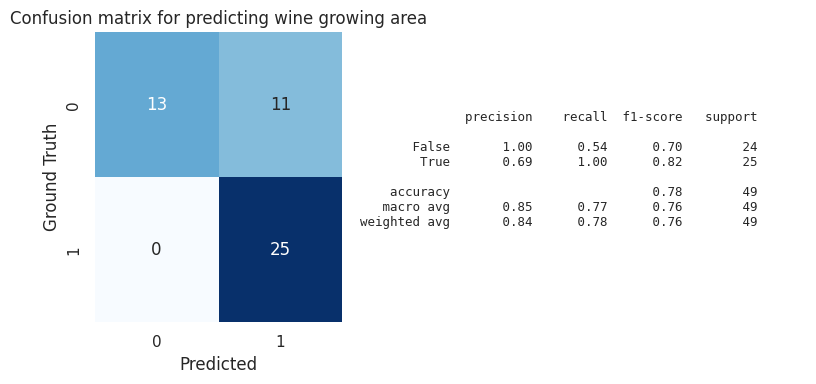

In [44]:
# Display results
#TODO: try to make the ConfusionMatrixDisplay work
from sklearn.metrics import ConfusionMatrixDisplay

plt.figure(figsize=(8, 4))
sns.set_theme()

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

plt.subplot(1,2,1)
sns.heatmap(conf_matrix, annot=True,
            fmt='d', cmap='Blues', cbar=False )

plt.title('Confusion matrix for predicting wine growing area')
plt.xlabel('Predicted')
plt.ylabel('Ground Truth')

plt.grid(None)

plt.subplot(1,2,2)
plt.text(0.0, 0.5, classification_rep, ha='center', va='center',
         fontsize=9, fontdict={'family': 'monospace'})
plt.axis('off')


plt.tight_layout()
plt.show()

OBSERVATIONS AND CONCLUSIONS

---


Indeed the agroclimatic and geospatial parameters define the wine producing potential of the area pretty well.

### Multinomial logistic regression / Multi-class Classifier

Let's consider the more difficult task of predicting the Winkler Index of an area around weather stations with multinomial regression.

In [66]:
from sklearn.preprocessing import StandardScaler

X = station_geo_agro_cepage_df.select_dtypes('float64')
y = station_geo_agro_cepage_df.winkler_index

X_train = X.loc[station_geo_agro_cepage_df.year < last_year]
y_train = y.loc[station_geo_agro_cepage_df.year < last_year]

X_test = X.loc[station_geo_agro_cepage_df.year == last_year]
y_test = y.loc[station_geo_agro_cepage_df.year == last_year]

scaler = StandardScaler().fit(X)
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.fit_transform(X_test)

In [69]:
from sklearn.model_selection import GridSearchCV

lr_multi = LogisticRegression(multi_class='multinomial', solver='lbfgs')

# Define hyperparameter grid for tuning
param_grid = {'C': [0.001, 0.1, 0.5, 1.0]}

# Use GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(lr_multi, param_grid, cv=5)
grid_search.fit(X_train_s, y_train)

# Get the best estimator from the grid search
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test_s)
accuracy = accuracy_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Best Hyperparameters:", grid_search.best_params_)

Accuracy: 0.3877551020408163
Best Hyperparameters: {'C': 1.0}


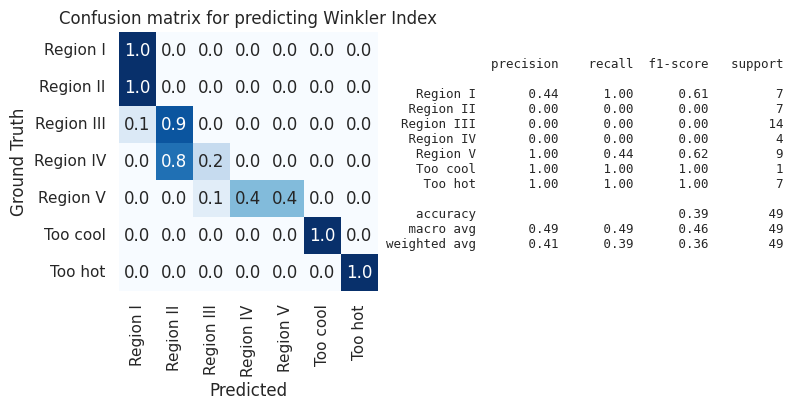

In [70]:
# Display results
conf_matrix = confusion_matrix(y_test, y_pred, normalize='true')
classification_rep = classification_report(y_test, y_pred)

plt.figure(figsize=(8, 4))

plt.subplot(1,2,1)
sns.heatmap(conf_matrix, annot=True, fmt='.1f',
            cmap='Blues', cbar=False, square=True,
            xticklabels = best_model.classes_,
            yticklabels = best_model.classes_,)

plt.title('Confusion matrix for predicting Winkler Index')
plt.xlabel('Predicted')
plt.ylabel('Ground Truth')

plt.subplot(1,2,2)
plt.text(0.5, 0.5, classification_rep, ha='center', va='center',
         fontsize=9, fontdict={'family': 'monospace'})
plt.axis('off')

plt.grid(None)
plt.tight_layout()
plt.show()

OBSERVATONS AND CONCLUSIONS

---

- the multinomial logistic regression did not give us the spectacular results
- at least the confusion was primarily between adjacent classes

We can try the other classification models though.

### Decision tree

Winkler Index classifier. We use the same data as before in the Multinomial classifier section.

##### Using default hyperparameters

In [71]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text

# Create a decision tree model
decision_tree = DecisionTreeClassifier(random_state=42)

# Fit the decision tree model on the training data
decision_tree.fit(X_train, y_train)

display(decision_tree)
print(pd.DataFrame([decision_tree.feature_importances_.round(2)],
                   columns=decision_tree.feature_names_in_,
                   index=['feature importance']))

# Print the decision tree rules
tree_rules = export_text(decision_tree,
                         feature_names=list(decision_tree.feature_names_in_))
print("Decision Tree Rules:")
print(tree_rules)

y_pred = decision_tree.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Max depth:", decision_tree.get_depth())
print('Max leaves:', decision_tree.get_n_leaves())

DecisionTreeClassifier(random_state=42)

                    lat  long  alt  GDD  GST  rainfall
feature importance  0.0   0.0  0.0  1.0  0.0       0.0
Decision Tree Rules:
|--- GDD <= 1389.03
|   |--- GDD <= 841.60
|   |   |--- class: Too cool
|   |--- GDD >  841.60
|   |   |--- class: Region I
|--- GDD >  1389.03
|   |--- GDD <= 1673.40
|   |   |--- class: Region II
|   |--- GDD >  1673.40
|   |   |--- GDD <= 2908.30
|   |   |   |--- GDD <= 1953.17
|   |   |   |   |--- class: Region III
|   |   |   |--- GDD >  1953.17
|   |   |   |   |--- GDD <= 2221.47
|   |   |   |   |   |--- class: Region IV
|   |   |   |   |--- GDD >  2221.47
|   |   |   |   |   |--- class: Region V
|   |   |--- GDD >  2908.30
|   |   |   |--- class: Too hot

Accuracy: 1.0
Max depth: 5
Max leaves: 7


OBSERVATIONS


---
- the decision tree model was able to reverse engineer the Winkler Index assignment attributing it to just one variable GDD. Original values for the Winkler index were [< 850, 1389,  1667, 1944, 2222, 2700, >2700].

To make sure that we did not overfit we can evaluate the model by doing the cross-validation.

In [77]:
#TODO: evaluate questionable value of this cell
from sklearn.model_selection import cross_val_score

X_s = scaler.fit_transform(X)

# Evaluate the models using crossvalidation
scores = cross_val_score(decision_tree, X_s, y, cv=5  )

print(scores)

[0.98214286 1.         0.99107143 0.99107143 1.        ]


##### Grid Search with cross validation

Let's see if we can stil find a good Decision Tree model if we exclude the `GDD` from the features.

In [78]:
from sklearn.model_selection import GridSearchCV

param_grid = {'max_depth': list(range(3,10)),
              'max_leaf_nodes': list(range(3,10))}

# Use GridSearchCV for hyperparameter tuning
decision_tree = DecisionTreeClassifier(random_state=42)
grid_search = GridSearchCV(decision_tree, param_grid, cv=5, verbose=0)
grid_search.fit(X_train.drop(columns='GDD'), y_train)

# Get the best estimator from the grid search
best_model = grid_search.best_estimator_

y_pred=best_model.predict(X_test.drop(columns='GDD'))

display(best_model)

print(pd.DataFrame([best_model.feature_importances_.round(2)],
                   columns=best_model.feature_names_in_,
                   index=['feature importance']))

print('accuracy:', accuracy_score(y_test, y_pred))

DecisionTreeClassifier(max_depth=5, max_leaf_nodes=7, random_state=42)

                     lat  long  alt   GST  rainfall
feature importance  0.15   0.0  0.0  0.85       0.0
accuracy: 0.9591836734693877


Click on the image to enlarge it


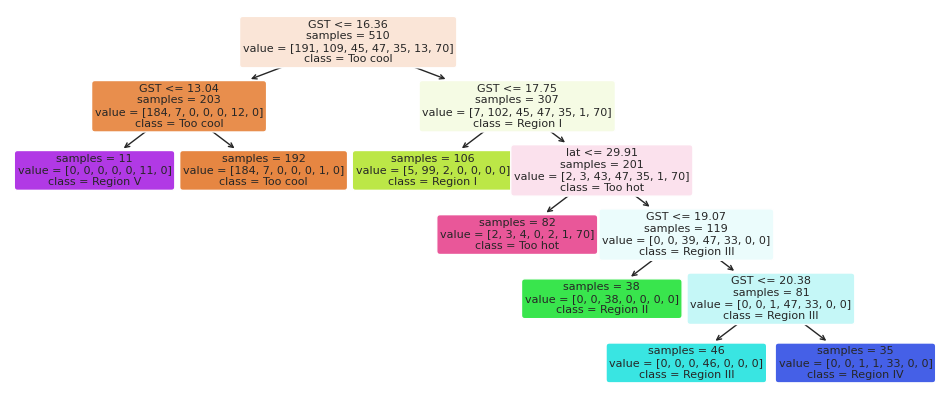

In [83]:
from sklearn.tree import plot_tree

plt.figure(figsize=(12, 5))

# Plot the decision tree
plot_tree(best_model,
          feature_names=list(best_model.feature_names_in_),
          class_names=y_test.cat.categories,
          label='all',
          filled=True,  rounded=True,
          impurity=False, proportion = False,
          fontsize =8,
          precision=2 )

print('Click on the image to enlarge it')
plt.show()

OBSERVATIONS AND CONCLUSIONS


---

TBF

Another way to visualize the same tree:

Click on the image to enlarge it


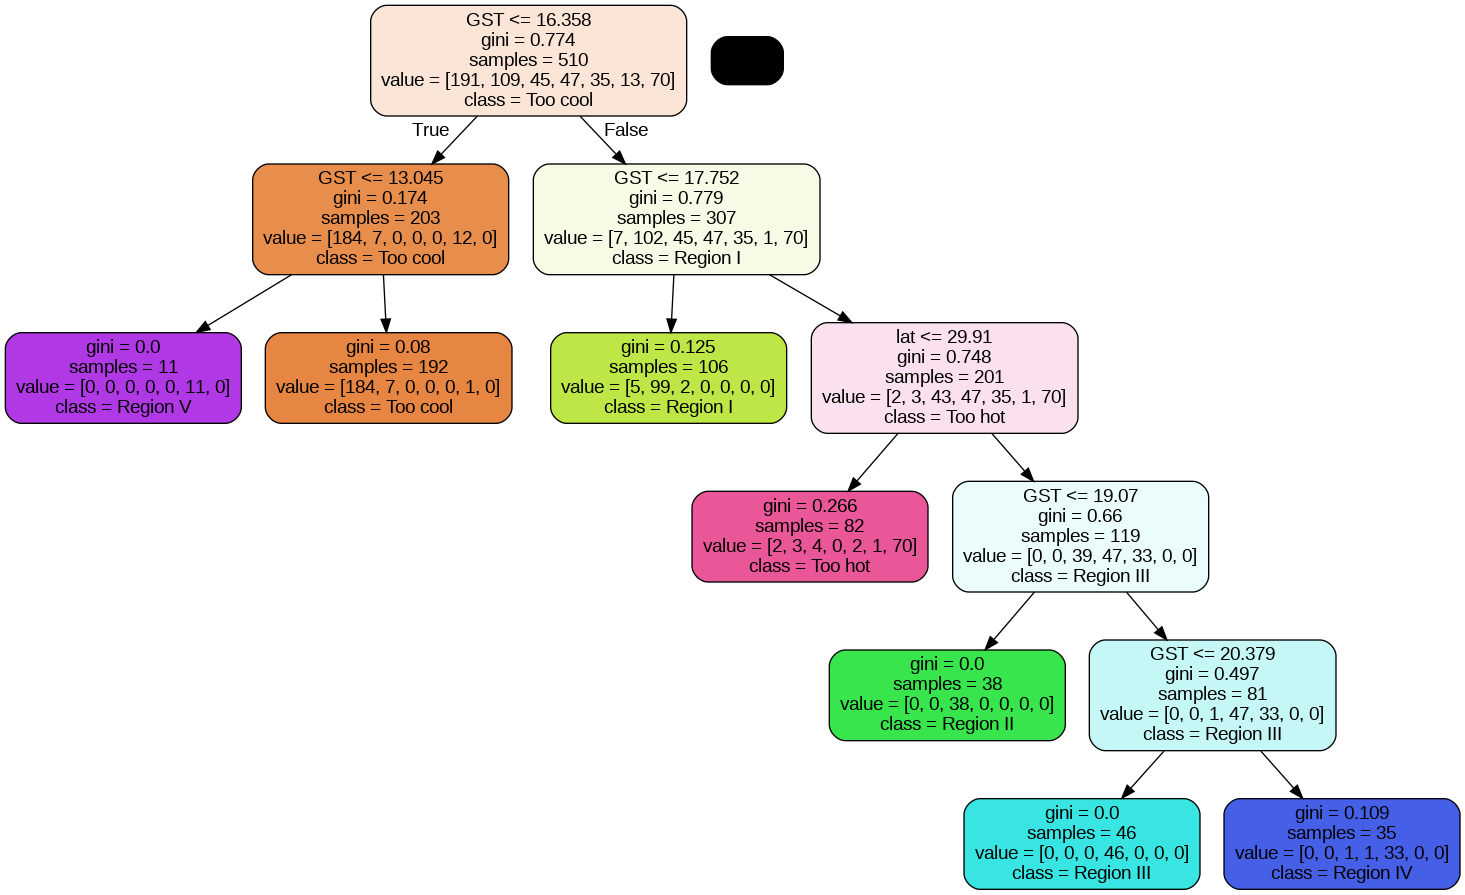

<Figure size 1200x500 with 0 Axes>

In [84]:
from sklearn.tree import export_graphviz
import pydotplus
from IPython.display import Image

plt.figure(figsize=(12, 5))

dot_data = export_graphviz(best_model, out_file=None,
                          feature_names=list(best_model.feature_names_in_),
                          class_names=y_test.cat.categories,
                          filled = True,
                          rounded= True)


# Draw graph
im = pydotplus.graph_from_dot_data(dot_data)

# Show graph
print('Click on the image to enlarge it')
Image(im.create_png())


### Random Forest

White Wines classifier

TBF

##### Data preprocessing

In [54]:
#TODO: try also the TimeSeriesSplit to see if we can use it to split
# the last year as a test set
#from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline


X = station_geo_agro_cepage_df.select_dtypes('float64')
y = station_geo_agro_cepage_df.WhiteWine.to_frame()

X_train = X.loc[station_geo_agro_cepage_df.year < last_year]
y_train = y.loc[station_geo_agro_cepage_df.year < last_year]

X_test = X.loc[station_geo_agro_cepage_df.year == last_year]
y_test = y.loc[station_geo_agro_cepage_df.year == last_year]

# define preprocessing pipeline for target
preproc_y = make_pipeline( SimpleImputer(missing_values=pd.NA,
                                        strategy='constant',
                                        fill_value='raisins'),
                         OrdinalEncoder(dtype='int'))

y_train = preproc_y.fit_transform(y_train).ravel()
y_test = preproc_y.fit_transform(y_test).ravel()

In [55]:
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

# Create a decision tree model
random_forest = RandomForestClassifier(random_state=42)

# Fit the decision tree model on the training data
random_forest.fit(X_train, y_train)

# Optionally, you can print the decision tree rules
#tree_rules = export_text(decision_tree, feature_names=list(decision_tree.feature_names_in_))
#print("Decision Tree Rules:")
#print(tree_rules)

display(random_forest)

print(pd.DataFrame([random_forest.feature_importances_.round(2)],
                   columns=random_forest.feature_names_in_,
                   index=['feature importance:']))

print('accuracy:' , random_forest.score(X_test, y_test) )
#print('depth:' , decision_tree.get_depth() )
#print('number of leaves:' , decision_tree.get_n_leaves() )


RandomForestClassifier(random_state=42)

                      lat  long   alt   GDD   GST  rainfall
feature importance:  0.24  0.32  0.19  0.11  0.11      0.03
accuracy: 0.9795918367346939


OBSERVATIONS AND CONCLUSIONS


---

TBF

It is not very practical to visualuze a tree from the _random forest_ model but for the demonstraion purposes we visualize the first estimator from the model.

The `sklearn.tree.plot_tree` function does not allow to choose leaf colors (at least we could not find the way to do it). Below we try another visualization way using `dtreeviz` package.

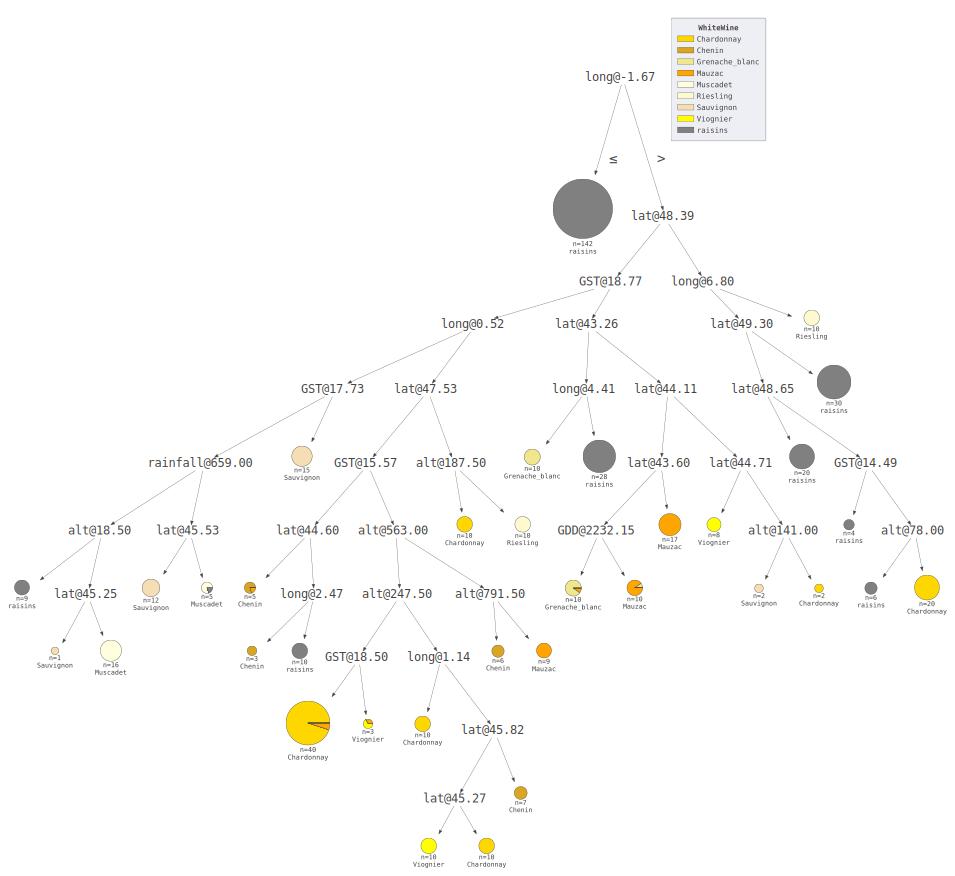

<Figure size 800x500 with 0 Axes>

In [56]:
plt.figure(figsize=(8,5))

# Visualize the decision tree using dtreeviz
viz = dtreeviz.model(random_forest.estimators_[0],
                    X_train=X_train,
                    y_train=y_train,
                    target_name='WhiteWine',
                    feature_names=random_forest.feature_names_in_,
                    class_names=list(preproc_y[-1].categories_[0]))

# Make up the color scheme for the classses
# In dtreeviz the color map has to be the the n-th element of a list,
# where n is the number of classes.
blanc_colors = ['gold', 'goldenrod',  'khaki', 'orange',
                'lightyellow',  'lemonchiffon',
                'wheat', 'yellow','gray', 'palegreen',  'navajowhite' ]

my_colors = [None] *  random_forest.n_classes_ + [blanc_colors]

viz.view(fancy=False,
         leaftype='pie',
         fontname="monospace",
         scale=1.0,
         colors={'classes': my_colors},
         )